In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# MNIST IMAGE --> Tensors
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)

In [7]:
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [11]:
type(test_data)

torchvision.datasets.mnist.MNIST

In [12]:
type(train_data[0])

tuple

In [13]:
image, label = train_data[0]

In [14]:
label

5

In [15]:
image.shape

torch.Size([1, 28, 28])

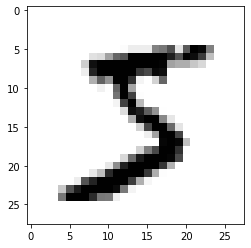

In [16]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg') #viridis

In [17]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False, pin_memory=True)

In [18]:
for x, y in train_loader:
    print(f'{x.device}\t{y.device}')
    break

cpu	cpu


In [19]:
from torchvision.utils import make_grid

In [20]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [21]:
# FIRST BATCH
for images, labels in train_loader:
    # 60,000 / 100 = 60 times
    break

In [22]:
images.shape

torch.Size([100, 1, 28, 28])

In [23]:
labels.shape

torch.Size([100])

In [24]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

Labels:  [   6    7    7    6    4    9    1    0    9    2    4    1]


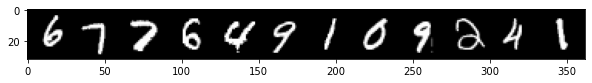

In [25]:
# Print the first 12 images
im = make_grid(images[:12], nrow=12) # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Labels:  [   6    7    7    6    4    9    1    0    9    2    4    1]


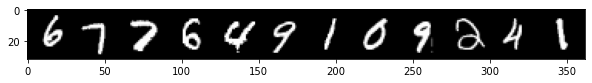

In [26]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())
# Print the first 12 images
im = make_grid(images[:12], nrow=12) # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [27]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [28]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model.to(device)

MultilayerPerceptron(
  (flatten): Flatten()
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
images.shape

torch.Size([100, 1, 28, 28])

In [32]:
images.view(100, -1).shape

torch.Size([100, 784])

In [33]:
%%time

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b += 1
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epoch: {i+1} batch: {b} loss: {loss.item():.5f} accuracy: {acc:.5f}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

Epoch: 1 batch: 200 loss: 0.27583 accuracy: 83.09000
Epoch: 1 batch: 400 loss: 0.21672 accuracy: 87.37250
Epoch: 1 batch: 600 loss: 0.21335 accuracy: 89.38833
Epoch: 2 batch: 200 loss: 0.13939 accuracy: 94.71000
Epoch: 2 batch: 400 loss: 0.12130 accuracy: 95.20000
Epoch: 2 batch: 600 loss: 0.11870 accuracy: 95.41833
Epoch: 3 batch: 200 loss: 0.12788 accuracy: 96.52500
Epoch: 3 batch: 400 loss: 0.09069 accuracy: 96.67750
Epoch: 3 batch: 600 loss: 0.09435 accuracy: 96.75167
Epoch: 4 batch: 200 loss: 0.04255 accuracy: 97.56500
Epoch: 4 batch: 400 loss: 0.08368 accuracy: 97.54750
Epoch: 4 batch: 600 loss: 0.04412 accuracy: 97.57000
Epoch: 5 batch: 200 loss: 0.15133 accuracy: 97.88500
Epoch: 5 batch: 400 loss: 0.10623 accuracy: 97.98000
Epoch: 5 batch: 600 loss: 0.14750 accuracy: 98.01333
Epoch: 6 batch: 200 loss: 0.04417 accuracy: 98.41000
Epoch: 6 batch: 400 loss: 0.05004 accuracy: 98.39500
Epoch: 6 batch: 600 loss: 0.05897 accuracy: 98.37833
Epoch: 7 batch: 200 loss: 0.00268 accuracy: 98

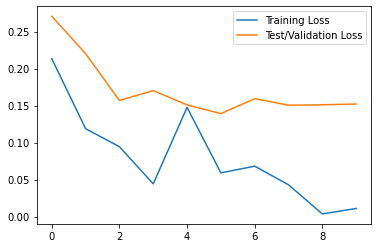

In [34]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.legend()

In [35]:
train_acc = [t/600 for t in train_correct]

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [36]:
test_acc =[t/600 for t in test_correct]

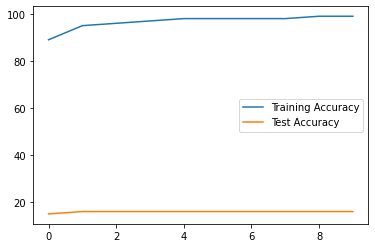

In [37]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()

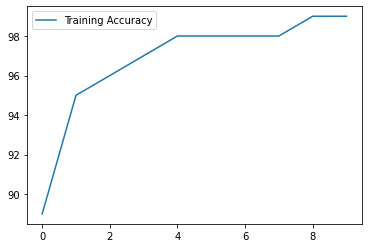

In [38]:
plt.plot(train_acc, label='Training Accuracy')
plt.legend()

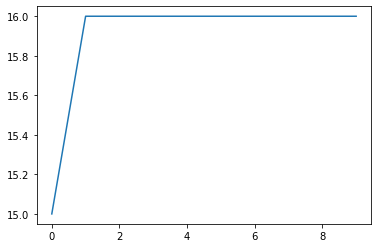

In [39]:
plt.plot(test_acc, label='Test Accuracy')

In [40]:
# NEW UNSEEN DATA
test_load_all = DataLoader(test_data, batch_size=10000, shuffle = False)
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat1' in call to _th_addmm

In [ ]:
100*correct.item()/len(test_data)

In [ ]:
confusion_matrix(predicted.view(-1), y_test.view(-1))